# Detecting electrode inversion in an ECG

The ECG is a time series that records the heart's electrical activity and serves as a primary tool for diagnosing heart diseases. Capturing an ECG is a straightforward process involving the placement of 3 electrodes at the limb ends and 6 on the front chest. This setup generates 12 time series known as leads, with each representing the potential difference between electrode pairs.

The accurate positioning of electrodes is crucial for correctly interpreting the ECG results. Inverting electrodes can lead to misinterpretations, causing the leads to explore unexpected areas and resulting in errors in hypertrophia index measurements or ST segment analysis. Additionally, false abnormalities like fake Q waves or errors in the heart's axis can be generated.

Inversion errors are relatively common, occurring in around 5% of ECGs. Only experts like cardiologists can typically identify them. However, the majority of ECGs are not examined by experts, with only 30% being interpreted by nurses or general practitioners. To address this issue and improve diagnostic quality, it is essential to develop an algorithm capable of automatically detecting electrode inversion in ECGs.

This project aims to create a method for detecting electrode inversion in ECGs using a dataset containing ECGs from a cardiology center. Each ECG in the dataset will be labeled as correctly realized (0) or inverted (1).

## Inversions

Electrode inversions can involve more than just the inversion of two leads. For example, in the precordial leads (V1, ..., V6), the inversion can occur differently, where V1 becomes V6 and V2 becomes V5, and so on. Moreover, when certain pairs of electrodes are exchanged, it affects multiple leads such as I, II, III, AVF, AVR, and AVL differently. For instance, if the electrodes of the right and left arms are inverted, then I becomes -I, II and III are inverted, AVL and AVR are inverted, while AVF remains unchanged. More information about the relationships between different leads and how they are affected by inversion can be found here: https://litfl.com/ecg-limb-lead-reversal-ecg-library/



## 1. Load and analyze the data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import train_test_split


2023-08-05 23:29:13.451519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

In [ ]:
input_training_file_path = "files/input_training.npy"
output_training_file_path = "files/output_training.npy"
input_testing_file_path = "files/input_test_set.npy"

input_train = np.load(input_training_file_path)
output_train = np.load(output_training_file_path)
input_test = np.load(input_testing_file_path)

print(input_train.shape)
print(output_train.shape)
print(input_test.shape)

(1400, 12, 2500)
(1400,)
(2630, 12, 2500)


### Analysis of the data

In [ ]:
print(np.unique(output_train, return_counts=True))

(array([0., 1.]), array([702, 698]))


We have 702 examples of correctly realized ECGs and 698 examples of inverted ECGs. We can say that both classes and balanced in term of the number of examples.

In [ ]:
print(np.sum(np.isnan(input_train)))
print(np.sum(np.isnan(output_train)))
print(np.sum(np.isnan(input_test)))

0
0
0


There are no missing values in the datasets.

We might want to check the training dataset's descriptive statistics:

In [ ]:

# Separate Correctly realized ECGs from Inverted ECGs
no_inversion_samples = input_train[output_train == 0.0]
inversion_samples = input_train[output_train == 1.0]


In [ ]:

def get_stats(data):
  """
    returns a pd.DataFrame containing the means, medians, standard deviations,
    maximums and minimums of all 12 leads for the whole time of sampling and
    for all the examples
  """

  leads_names = ["I", "II", "III", "AVF", "AVL", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]

  stats_names = ["Mean", "Median", "Standard deviation", "Maximum", "Minimum"]

  means = np.mean(data, axis = (0,2))
  medians = np.median(data, axis = (0,2))
  stds = np.std(data, axis = (0,2))
  maxs = np.max(data, axis = (0,2))
  mins = np.min(data, axis = (0,2))

  stacked_stats = np.stack([means, medians, stds, maxs, mins], axis=0, out=None)

  stats = pd.DataFrame(stacked_stats, index=stats_names, columns=leads_names)

  return stats


In [ ]:
get_stats(no_inversion_samples)

,I,II,III,AVF,AVL,AVR,V1,V2,V3,V4,V5,V6
Mean,0.024337,0.016054,-0.009481,0.016789,-0.020572,0.003036,-0.022922,-0.006779,0.005862,0.024956,0.034194,0.036460
Median,-0.001460,-0.000840,0.000200,-0.000670,0.001240,-0.000130,0.000050,-0.000010,0.000080,0.000000,0.000230,0.000120
Standard deviation,0.330904,0.264431,0.348491,0.321042,0.253751,0.261379,0.416700,0.521620,0.697024,0.729530,0.722206,0.780192
Maximum,16.685250,31.000000,31.000000,16.667160,10.173380,31.000000,31.000000,31.000000,31.000000,31.000000,31.013950,31.000000
Minimum,-8.978800,-11.346870,-16.636140,-22.742440,-22.752210,-8.360110,-26.813770,-16.075350,-31.000000,-31.006160,-31.503730,-27.240210


In [ ]:
get_stats(inversion_samples)

,I,II,III,AVF,AVL,AVR,V1,V2,V3,V4,V5,V6
Mean,0.00537,0.005619,0.000694,0.002140,-0.005667,0.002892,-0.011674,0.003066,0.012848,0.022710,0.027735,0.024617
Median,-0.00027,-0.000280,-0.000160,-0.000030,0.000370,-0.000270,0.000040,-0.000560,-0.000230,-0.000280,-0.000060,-0.000260
Standard deviation,0.29863,0.298040,0.266431,0.255781,0.280456,0.260668,0.422698,0.492160,0.569549,0.436147,0.433375,0.494653
Maximum,31.00000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
Minimum,-31.00000,-31.000040,-31.000000,-31.000000,-22.725520,-22.831450,-18.220210,-17.034470,-27.378700,-7.518460,-15.368900,-31.000000


It seems that there are differences in the values between the Correctly realised ECGs and the Inverted ECGs. Specially for some leads where the difference is significant.

In [ ]:
get_stats(no_inversion_samples).loc[["Minimum"],:].append(get_stats(inversion_samples).loc[["Minimum"],:])

<ipython-input-12-0447283e21e7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  get_stats(no_inversion_samples).loc[["Minimum"],:].append(get_stats(inversion_samples).loc[["Minimum"],:])


,I,II,III,AVF,AVL,AVR,V1,V2,V3,V4,V5,V6
Minimum,-8.9788,-11.34687,-16.63614,-22.74244,-22.75221,-8.36011,-26.81377,-16.07535,-31.0000,-31.00616,-31.50373,-27.24021
Minimum,-31.0000,-31.00004,-31.00000,-31.00000,-22.72552,-22.83145,-18.22021,-17.03447,-27.3787,-7.51846,-15.36890,-31.00000


For example, the minimum values of the correctly realised ECGs and the inverted ECGs and differents in all leads and the difference is quite significant.

In [ ]:
get_stats(no_inversion_samples).loc[["Maximum"],:].append(get_stats(inversion_samples).loc[["Maximum"],:])

<ipython-input-13-49dd6dbcc992>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  get_stats(no_inversion_samples).loc[["Maximum"],:].append(get_stats(inversion_samples).loc[["Maximum"],:])


,I,II,III,AVF,AVL,AVR,V1,V2,V3,V4,V5,V6
Maximum,16.68525,31.0,31.0,16.66716,10.17338,31.0,31.0,31.0,31.0,31.0,31.01395,31.0
Maximum,31.00000,31.0,31.0,31.00000,31.00000,31.0,31.0,31.0,31.0,31.0,31.00000,31.0


We observe that for some leads (I, AVF, AVL), the maximum values are differents but for the rest, the values are close or equal.

We suspect that these differences are mainly due to the inversion, but other factors might influence theses results, Therefore, we might need to explore further information.

Let's visualize two random examples, one from the inverted ECGs and the other from the correctly realised ECGs:

In [ ]:
# Picking a random example from inverted ECGs
random_inv_sample = inversion_samples[np.random.randint(0, inversion_samples.shape[0]), :, :]

# Picking a random example from correctly realised ECGs
random_no_inv_sample = no_inversion_samples[np.random.randint(0, no_inversion_samples.shape[0]), :, :]

# Limit the range of the signal to be displayed
limit = 600

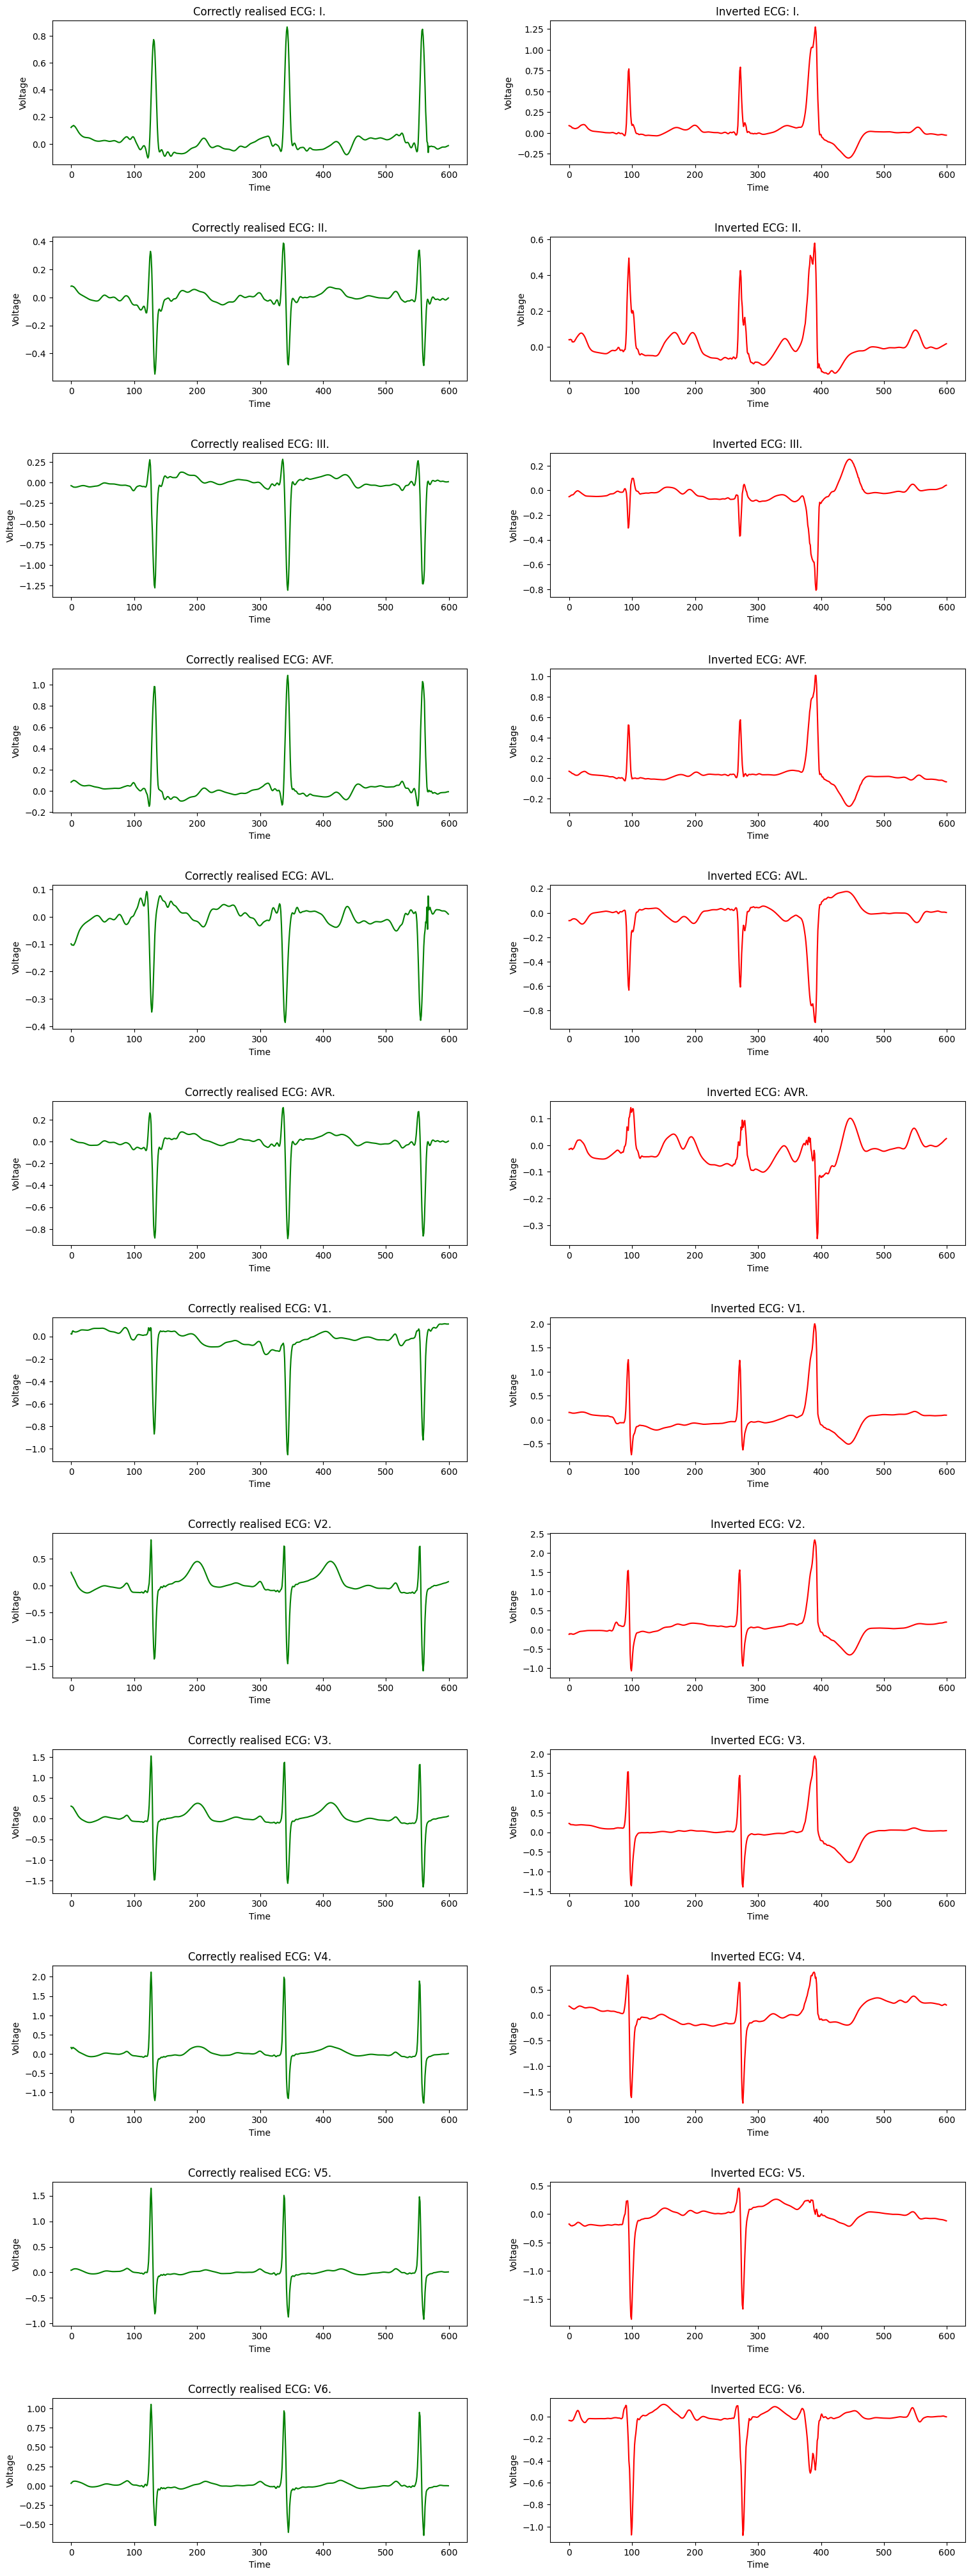

In [ ]:

# Leads names
leads_names = ["I", "II", "III", "AVF", "AVL", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]
keys = np.arange(12)
leads_channels = dict(list(zip(keys, leads_names)))

fig, axs = plt.subplots(12, 2, figsize=(15, 40))

fig.tight_layout()

fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(12):
  axs[i, 0].plot(random_no_inv_sample[i,:limit], color="g")   # Correctly realised ECG
  axs[i, 0].set_title("Correctly realised ECG: {}.".format(leads_channels[i]))
  axs[i, 1].plot(random_inv_sample[i,:limit], color="r")      # Inverted ECG
  axs[i, 1].set_title("Inverted ECG: {}.".format(leads_channels[i]))

for ax in axs.flat:
  ax.set(xlabel='Time', ylabel='Voltage')

# axs[12, 0].imshow(random_inv_sample[:,:limit], interpolation='nearest', aspect='auto');
# axs[12, 0].set(xlabel='Time', ylabel='Leads')
# axs[12, 0].set_title("Inverted ECG");
# axs[12, 1].imshow(random_no_inv_sample[:,:limit], interpolation='nearest', aspect='auto');
# axs[12, 1].set(xlabel='Time', ylabel='Leads')
# axs[12, 1].set_title("Correctly realised ECG");


Here is another way to visualize the ECGs (all 12 leads together), as a grayscal image where the pixel intensities indicate the voltage:

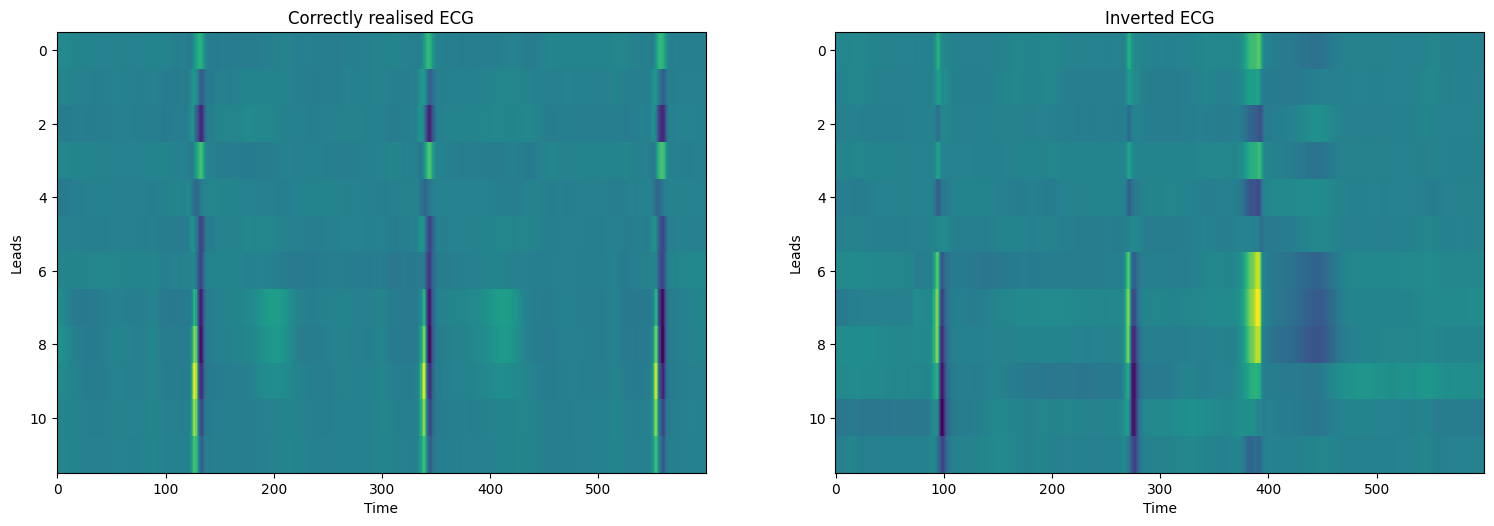

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.tight_layout()

fig.subplots_adjust(hspace=0.5, wspace=0.2)

axs[0].imshow(random_no_inv_sample[:,:limit], interpolation='nearest', aspect='auto');
axs[0].set(xlabel='Time', ylabel='Leads')
axs[0].set_title("Correctly realised ECG");

axs[1].imshow(random_inv_sample[:,:limit], interpolation='nearest', aspect='auto');
axs[1].set(xlabel='Time', ylabel='Leads')
axs[1].set_title("Inverted ECG");


## 2. Classification using the raw signal
The goal here is to perform classification using directly the raw data.

#### Prepare and split the data:

In [ ]:
x = input_train.reshape(1400, 12, 2500, 1)

y = output_train

split_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split_size, random_state=42, stratify=y)

#### Model definition

In [ ]:

model = Sequential()

model.add(Conv2D(32, (12, 31), input_shape=x.shape[1:]))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(32, (1, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(32, (1, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(64, (1, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Flatten())

model.add(Dense(8))
model.add(Dense(8))
model.add(Dense(8))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 1, 2470, 32)       11936     
                                                                 
 activation_93 (Activation)  (None, 1, 2470, 32)       0         
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 1, 1235, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 1, 1233, 32)       3104      
                                                                 
 activation_94 (Activation)  (None, 1, 1233, 32)       0         
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 1, 616, 32)       0         
 g2D)                                                

#### Model training

In [ ]:
result = model.fit(X_train, y_train, batch_size=4096, epochs=40, validation_split=0.2)


Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.6932 - accuracy: 0.4783 - val_loss: 0.6904 - val_accuracy: 0.5306
Epoch 2/40
1/1 [==============================] - 0s 297ms/step - loss: 0.6842 - accuracy: 0.5268 - val_loss: 0.6872 - val_accuracy: 0.5153
Epoch 3/40
1/1 [==============================] - 0s 216ms/step - loss: 0.6725 - accuracy: 0.5434 - val_loss: 0.6826 - val_accuracy: 0.5612
Epoch 4/40
1/1 [==============================] - 0s 221ms/step - loss: 0.6560 - accuracy: 0.6352 - val_loss: 0.6768 - val_accuracy: 0.6224
Epoch 5/40
1/1 [==============================] - 0s 259ms/step - loss: 0.6338 - accuracy: 0.7321 - val_loss: 0.6684 - val_accuracy: 0.6020
Epoch 6/40
1/1 [==============================] - 0s 222ms/step - loss: 0.6055 - accuracy: 0.7462 - val_loss: 0.6535 - val_accuracy: 0.6276
Epoch 7/40
1/1 [==============================] - 0s 245ms/step - loss: 0.5703 - accuracy: 0.7640 - val_loss: 0.6367 - val_accuracy: 0.6429
Epoch 8/40
1/1 [=======

#### Model evaluation

In [ ]:
model_eval = model.evaluate(X_test, y_test, 8)
print('test loss: \n', model_eval[0])
print('test acc: \n', model_eval[1])

53/53 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.7667
test loss: 
 0.6662734746932983
test acc: 
 0.7666666507720947


14/14 [==============================] - 0s 4ms/step
Confusion matrix: 
[[157  54]
 [ 44 165]]

Accuracy score: 
0.7666666666666667

Recall score: 
[0.74407583 0.78947368]

Precision score: 
[0.78109453 0.75342466]



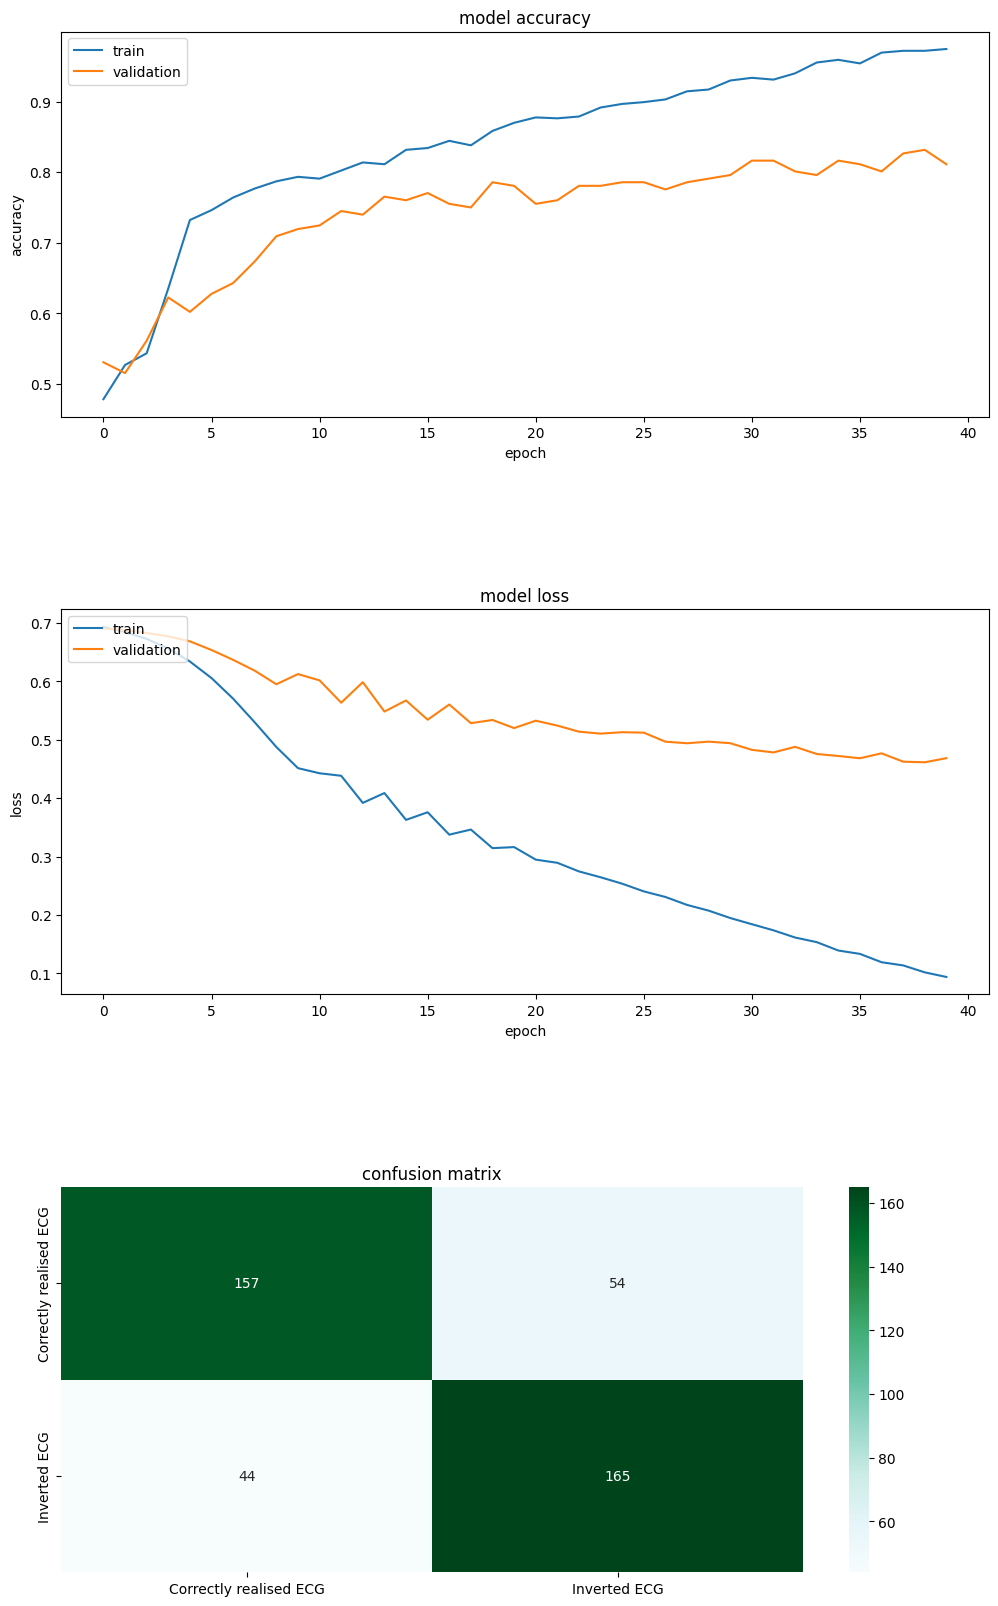

In [ ]:

prediction = model.predict(X_test);

print("Confusion matrix: ")
print(confusion_matrix(y_test, np.rint(prediction)))
print()

print("Accuracy score: ")
print(accuracy_score(y_test, np.rint(prediction)))
print()

print("Recall score: ")
print(recall_score(y_test, np.rint(prediction), average=None))
print()

print("Precision score: ")
print(precision_score(y_test, np.rint(prediction), average=None))
print()


classes = ["Correctly realised ECG", "Inverted ECG"]
cm = pd.DataFrame(confusion_matrix(y_test, np.rint(prediction)), index=classes, columns=classes)

fig, axs = plt.subplots(3, 1, figsize = (10, 16))

fig.tight_layout()

fig.subplots_adjust(hspace=0.5, wspace=0.2)

axs[0].plot(result.history['accuracy'])
axs[0].plot(result.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(result.history['loss'])
axs[1].plot(result.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

hm = sn.heatmap(cm, annot=True, fmt='.4g', cmap='BuGn', ax=axs[2])
hm.set_title("confusion matrix")

plt.show()

For the trained model:
* We see that the accuracy of the model on the training and validation set increases as the training keeps going on.

* It appears that the accuracy on the test set is close to the accuracy on the training set as well as to the accuracy on the validation set.

* The loss on the training set keeps decreasing. Similarly, the loss on the validation set globally decreases eventhough it keep fluctuating.

* After multiple trainings and evaluations, we had accuracies between 0.80 and 0.88.

## 3. Prediction on the test set


In [ ]:
testing_set = input_test.reshape(2630, 12, 2500, 1)

test_predictions = model.predict(testing_set)

final_predictions = ((test_predictions > 0.5) * 1.0).reshape(-1)

print(np.unique(final_predictions))
print(final_predictions.shape)
print(type(final_predictions))

print('Saving test predictions ...')
with open('predictions.npy', 'wb') as f:
  np.save(f, final_predictions)

83/83 [==============================] - 2s 21ms/step
[0. 1.]
(2630,)
<class 'numpy.ndarray'>
Saving test predictions ...


In [ ]:
model.save('path/to/ecg_inversion_model.keras')
model.save('path/to/ecg_inversion_model.tf', save_format='tf')
model.save('path/to/ecg_inversion_model.h5', save_format='h5')

In [ ]:
imported_model = load_model('path/to/ecg_inversion_model.keras')

In [ ]:
x_test = input_test[0,:,:]
x_test = x_test.reshape((1,12,2500,1))
imported_model_test_predictions = imported_model.predict(x_test)

In [ ]:
!zip -r model.zip path/

  adding: path/ (stored 0%)
  adding: path/to/ (stored 0%)
  adding: path/to/ecg_inversion_model.h5 (deflated 12%)
  adding: path/to/ecg_inversion_model.keras (deflated 12%)
  adding: path/to/ecg_inversion_model.tf/ (stored 0%)
  adding: path/to/ecg_inversion_model.tf/fingerprint.pb (stored 0%)
  adding: path/to/ecg_inversion_model.tf/keras_metadata.pb (deflated 93%)
  adding: path/to/ecg_inversion_model.tf/variables/ (stored 0%)
  adding: path/to/ecg_inversion_model.tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: path/to/ecg_inversion_model.tf/variables/variables.index (deflated 67%)
  adding: path/to/ecg_inversion_model.tf/saved_model.pb (deflated 89%)
  adding: path/to/ecg_inversion_model.tf/assets/ (stored 0%)
